In [1]:
%%capture --no-display
import warnings
warnings.filterwarnings('ignore')

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, laplacian

## Best eigenmode matches from correlation optimization

In [2]:
%matplotlib inline

# House keeping
plt.style.use('seaborn')
data_dir = '../../../data'
hcp_dir = "../../../data"

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

# binarize:
ub, lb = 1, 0 #define binary boundaries

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )
    
DK_df_normalized

,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,0.609756,0.072298,0.517443,0.00201,0.002988,0.002238,0.531757,0.153381,0.820943,0.000865,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.184615,0.0,0.0,NaN
Dorsal_Attention,0.000000,0.000000,0.147862,0.00000,0.000000,0.139721,0.165546,0.314169,0.000000,0.040678,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN
Frontoparietal,0.000000,0.324982,0.334696,0.00000,0.000000,0.000000,0.184687,0.187768,0.069145,0.000000,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN
Limbic,0.000000,0.000000,0.000000,0.00000,0.997012,0.376033,0.000000,0.323887,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.140625,NaN,0.269231,1.0,1.0,NaN
Somatomotor,0.251307,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.062500,NaN,0.000000,0.0,0.0,NaN
Ventral_Attention,0.138937,0.602720,0.000000,0.00000,0.000000,0.000000,0.000158,0.000000,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.796875,NaN,0.000000,0.0,0.0,NaN
Visual,0.000000,0.000000,0.000000,0.99799,0.000000,0.482008,0.117852,0.020795,0.109912,0.958457,...,NaN,1.0,NaN,NaN,0.000000,NaN,0.546154,0.0,0.0,NaN


### Load Basin Hopping results:

Default network:

In [3]:
colnames = ['Fun','x']
indnames = [0,1,2,3,4,5,6,7,8,9]
nruns = 10
default_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    #h5_path = path.get_file_path('laplacian_networks/Default{}_BH_corr.h5'.format(i))
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Default{}_BH_corr.h5'.format(i))
    bh_default = path.read_hdf5(h5_path)
    default_corrs.at[i,'Fun'] = -bh_default['fun']
    default_corrs.at[i,'x'] = np.round(bh_default['x'],3)
    
default_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun'])

,Fun,x
0,0.602879,[2.34 5.798]
1,0.370432,[ 2.522 98.547]
2,0.503531,[ 2.322 48.547]
3,0.340499,[ 0.466 205.693]
4,0.414246,[ 3.297 418.416]
5,0.60755,[ 2.969 30.411]
6,0.403145,[ 4.22 271.003]
7,0.38503,[ 0.839 160.404]
8,0.412952,[ 0.373 312.046]
9,0.331286,[ 2.38 519.787]


Dorsal Attention:

In [4]:
dorsal_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Dorsal_Attention{}_BH_corr.h5'.format(i))
    bh_dorsal = path.read_hdf5(h5_path)
    dorsal_corrs.at[i,'Fun'] = -bh_dorsal['fun']
    dorsal_corrs.at[i,'x'] = np.round(bh_dorsal['x'],3)

dorsal_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun'])

,Fun,x
0,0.5786,[ 4.658 11.307]
1,0.464757,[ 2.522 98.547]
2,0.610756,[ 2.596 78.541]
3,0.45249,[ 2.916 200.935]
4,0.462132,[ 3.119 421.769]
5,0.559202,[ 3.402 12.992]
6,0.383724,[ 2.362 262.897]
7,0.451062,[ 2.419 164.99 ]
8,0.48945,[ 3.167 304.925]
9,0.481462,[ 2.497 505.569]


Frontoparietal:

In [5]:
front_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Frontoparietal{}_BH_corr.h5'.format(i))
    bh_front = path.read_hdf5(h5_path)
    front_corrs.at[i,'Fun'] = -bh_front['fun']
    front_corrs.at[i,'x'] = np.round(bh_front['x'],3)

front_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun'])

,Fun,x
0,0.547805,[ 2.624 33.931]
1,0.523766,[ 3.286 102.509]
2,0.561275,[ 2.435 65.25 ]
3,0.441133,[ 3.04 202.651]
4,0.440538,[ 2.57 401.078]
5,0.655676,[ 2.931 42.27 ]
6,0.393424,[ 4.383 268.975]
7,0.4879,[ 0.319 161.171]
8,0.427814,[ 4.06 308.085]
9,0.495145,[ 4.346 504.75 ]


In [13]:
limbic_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    #h5_path = path.get_file_path('laplacian_networks/Limbic{}_BH_corr.h5'.format(i))
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Limbic{}_BH_corr.h5'.format(i))
    bh_limbic = path.read_hdf5(h5_path)
    limbic_corrs.at[i,'Fun'] = -bh_limbic['fun']
    limbic_corrs.at[i,'x'] = np.round(bh_limbic['x'],3)

limbic_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun']) # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.446987,[2.022 3.547]
1,0.452566,[ 2.522 98.547]
2,0.562897,[ 3.925 74.848]
3,0.480727,[ 2.322 198.547]
4,0.384429,[ 0.669 410.115]
5,0.431936,[ 3.72 15.242]
6,0.485161,[ 2.158 253.818]
7,0.475254,[ 3.108 172.241]
8,0.338131,[ 3.231 299.477]
9,0.331024,[ 0.583 524.448]


Somatomotor:

In [7]:
motor_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Somatomotor{}_BH_corr.h5'.format(i))
    bh_motor = path.read_hdf5(h5_path)
    motor_corrs.at[i,'Fun'] = -bh_motor['fun']
    motor_corrs.at[i,'x'] = np.round(bh_motor['x'],3)

motor_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun']) # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.470076,[ 0.624 17.841]
1,0.595503,[ 1. 100.]
2,0.594669,[ 3.042 48.79 ]
3,0.489211,[ 3.751 214.531]
4,0.347006,[ 3.92 415.537]
5,0.564937,[ 2.916 31.009]
6,0.348189,[ 3.416 248.726]
7,0.493339,[ 2.866 148.71 ]
8,0.55479,[ 4.037 331.947]
9,0.406929,[4.40000e-01 5.11994e+02]


Ventral Attention:

In [8]:
ventral_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    #h5_path = path.get_file_path('laplacian_networks/v1_3parameters/Ventral_Attention{}_BH_corr.h5'.format(i))
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Ventral_Attention{}_BH_corr.h5'.format(i))
    bh_ventral = path.read_hdf5(h5_path)
    ventral_corrs.at[i,'Fun'] = -bh_ventral['fun']
    ventral_corrs.at[i,'x'] = np.round(bh_ventral['x'],3)

ventral_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun']) # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.557085,[2.022 3.547]
1,0.544911,[ 1.138 115.494]
2,0.576888,[ 3.321 60.765]
3,0.453288,[ 2.865 217.92 ]
4,0.44779,[ 1.458 402.315]
5,0.517073,[ 3.544 42.143]
6,0.366238,[ 1.167 258.352]
7,0.436086,[ 1.298 152.032]
8,0.453913,[ 1.393 317.438]
9,0.482277,[ 2.74 528.077]


Visual:

In [9]:
visual_corrs = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,nruns):
    h5_path = path.get_file_path('laplacian_networks/final_bounds/Visual{}_BH_corr.h5'.format(i))
    bh_visual = path.read_hdf5(h5_path)
    visual_corrs.at[i,'Fun'] = -bh_visual['fun']
    visual_corrs.at[i,'x'] = np.round(bh_visual['x'],3)

visual_corrs.style.apply(functions.highlight_max, subset=pd.IndexSlice[:,'Fun']) # in case of a draw, take lowest reconstruction error

OSError: ``/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/laplacian_networks/final_bounds/Visual4_BH_corr.h5`` does not exist

### Concatenate reconstruction errors and plot to check for optimal number of sorted eigenmodes:

Text(0, 0.5, '$r^{2}$ score')

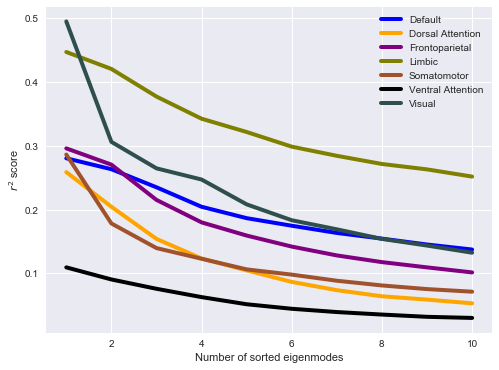

In [3]:
from cycler import cycler

r2s = np.zeros([7,10])

h5_path = path.get_file_path('laplacian_networks/Default9_BH_corr.h5')
bh_default = path.read_hdf5(h5_path)
r2s[0,:] = [bh_default['LinRegResults'][i]['r2score'] for i in range(len(bh_default['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Dorsal_Attention4_BH_corr.h5')
bh_dorsal = path.read_hdf5(h5_path)
r2s[1,:] = [bh_dorsal['LinRegResults'][i]['r2score'] for i in range(len(bh_dorsal['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Frontoparietal6_BH_corr.h5')
bh_front = path.read_hdf5(h5_path)
r2s[2,:] = [bh_front['LinRegResults'][i]['r2score'] for i in range(len(bh_front['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Limbic9_BH_corr.h5')
bh_limbic = path.read_hdf5(h5_path)
r2s[3,:] = [bh_limbic['LinRegResults'][i]['r2score'] for i in range(len(bh_limbic['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Somatomotor6_BH_corr.h5')
bh_motor = path.read_hdf5(h5_path)
r2s[4,:] = [bh_motor['LinRegResults'][i]['r2score'] for i in range(len(bh_motor['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Ventral_Attention8_BH_corr.h5')
bh_ventral = path.read_hdf5(h5_path)
r2s[5,:] = [bh_ventral['LinRegResults'][i]['r2score'] for i in range(len(bh_ventral['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Visual2_BH_corr.h5')
bh_visual = path.read_hdf5(h5_path)
r2s[6,:] = [bh_visual['LinRegResults'][i]['r2score'] for i in range(len(bh_visual['LinRegResults']))]

# Plot
x = np.arange(1,11)
plt.figure('Reconstruction Scores', figsize = [8,6])
custom_cycler = (cycler(color = ['blue','orange','purple','olive',
                          'sienna','black','darkslategray']))
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, r2s.transpose(), linewidth = 4)
plt.legend(['Default','Dorsal Attention','Frontoparietal','Limbic','Somatomotor','Ventral Attention','Visual'],
          fontsize = 'medium', loc = 'upperright')
plt.xlabel('Number of sorted eigenmodes')
plt.ylabel('$r^{2}$ score')

In [6]:
print(bh_default['x'])
print(bh_default['fun'])

[38.28444667  0.29051745  2.89491841]
-0.5294311452069379


In [7]:
print(bh_limbic['x'])
print(bh_limbic['fun'])

[39.71283473  2.54712621  2.12483571]
-0.6683971920179946


In [8]:
print(bh_visual['x'])
print(bh_visual['fun'])

[33.09658358  0.11916613  0.83241506]
-0.7033225557998363


In [9]:
print(bh_motor['x'])
print(bh_motor['fun'])

[13.87955724  0.23302648  1.64897224]
-0.5349185030883689


In [10]:
print(bh_front['x'])
print(bh_front['fun'])

[29.40115166  0.56164091  1.37504622]
-0.543911391971643


In [11]:
print(bh_dorsal['x'])
print(bh_dorsal['fun'])

[28.10447454  0.17328094  2.242411  ]
-0.508558922054213


In [12]:
print(bh_ventral['x'])
print(bh_ventral['fun'])

[40.84702068  3.31175759  0.10352365]
-0.3307948381303105


In [24]:
warnings.filterwarnings('ignore')

K = 86 # for number of eigenmodes
#print(bh_default['x'])

#create brain object:
fc_brain = Brain.Brain()
fc_brain.add_connectome(hcp_dir)
fc_brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
fc_brain.bi_symmetric_c()
fc_brain.reduce_extreme_dir()

regr_all = np.zeros([K,7]) 
dice_all = np.zeros([K,7])
corr_all = np.zeros([K,7])
_, _, _, ordered_corr = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_ventral['x'][0], a = bh_ventral['x'][1], 
                                           s = bh_ventral['x'][2], fc_name = 'Ventral_Attention', num_em = K)
print(ordered_corr)

[70 75 38 53 77 72 58 49 79 50 42 56 44 78 31 62 64 10  6 51 59  4 41 66
 29 18 71 24  9 35 48 55 57 11  2 36 15 54 52 37 46 16 28 14  3 80 32 26
  7 30 19 13 22 21 23 43 12 39  5 74 34 45  1 20 60 47 65 82 33 25 85 67
 84 76 73 83 17 61 27 40 68 81  0  8 63 69]


## Expand the above plot to 35 eigenmodes and DICE:

In [13]:
#from sklearn.linear_model import LinearRegression
from scipy.spatial import distance
from sklearn.preprocessing import minmax_scale
from scipy.stats import pearsonr
#from sklearn.metrics import mean_squared_error

def compute_linreg_scores(brain, fnetworks, df_binarized, f, a, s, fc_name, num_em):
    w = 2*np.pi*f
    
    brain.add_laplacian_eigenmodes(w = w, alpha = a, speed = s, vis = False)
    # binarize:
    thresh_vec = np.linspace(0.1,0.8,30)
    binary_count = np.zeros(thresh_vec.shape)
    for i in np.arange(0,len(thresh_vec)):
        binary_mat = np.where(brain.norm_eigenmodes > thresh_vec[i],1,0)
        binary_count[i] = np.count_nonzero(binary_mat)
        
    num_canonical = np.count_nonzero(df_binarized.loc[fc_name].values)
    bin_num = np.abs(binary_count - num_canonical).argmin()
    brain.binary_eigenmodes = np.where(brain.norm_eigenmodes > thresh_vec[bin_num], 1, 0)
        
    opt_dice = eigenmode.get_dice_df(brain.binary_eigenmodes, df_binarized)
    ntw_opt_dice = np.round(opt_dice[fc_name].values.astype(np.double),3)
    ordered_dice = np.argsort(ntw_opt_dice)
    
    canon_network = np.nan_to_num(fnetworks.loc[fc_name].values)
    corrs = np.squeeze(np.zeros([brain.norm_eigenmodes.shape[1],1]))
    for e in np.arange(0, len(corrs)):
        prcorr = pearsonr(np.squeeze(canon_network), brain.norm_eigenmodes[:,e])[0]
        corrs[e] = prcorr
        
    ntw_opt_corr = np.round(corrs,3)
    ordered_corr = np.argsort(-ntw_opt_corr)
    #assert ntw_opt_dice[ordered_dice[1]] > ntw_opt_dice[ordered_dice[0]]
    
    cumulative_dice = np.zeros([num_em,1])
    cumulative_regr = np.zeros([num_em,1])
    cumulative_corr = np.zeros([num_em,1])
    num_canonical = np.count_nonzero(df_binarized.loc[fc_name].values)
    thresh_vec = np.linspace(0.1,0.8,30)
    binary_count = np.zeros(thresh_vec.shape)
    
    for k in np.arange(0,num_em):
        selected_eigs = brain.norm_eigenmodes[:,ordered_dice[0:k+1]]
        canon_network = np.nan_to_num(fnetworks.loc[fc_name].values).reshape(-1,1)
        dcoef, dice_r, _, _ = np.linalg.lstsq(selected_eigs, canon_network, rcond = None)
        
        #cumulative_regr[k] = regr.score(canon_network, selected_eigs) #r2 score
        # dice:
        comb_eigmodes = np.matmul(selected_eigs, np.asarray(dcoef))
        #comb_eigmodes = np.squeeze(minmax_scale(comb_eigmodes))
        ## binarize each combination differently:
        for i in np.arange(0,len(thresh_vec)):
            binary_mat = np.where(comb_eigmodes > thresh_vec[i],1,0)
            binary_count[i] = np.count_nonzero(binary_mat)
        
        bin_num = np.abs(binary_count - num_canonical).argmin()
        binary_comb = np.where(comb_eigmodes > thresh_vec[bin_num], 1, 0)
        #print('{} element count: {}, eigenmode element count: {}'.format(fc_name, num_canonical, np.count_nonzero(binary_comb)))
        cumulative_dice[k] = 1-distance.dice(binary_comb, df_binarized.loc[fc_name].values)
        # spatial correlation
        corr_eigs = brain.norm_eigenmodes[:,ordered_corr[0:k+1]]
        coef, residual, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
        
        comb_corr = np.matmul(corr_eigs, np.asarray(coef))
        comb_corr = np.squeeze(minmax_scale(comb_corr))
        #comb_corr = np.squeeze(comb_corr)
        # regression fit
        if residual.shape[0] == 0:
            residual = 0
            
        cumulative_regr[k] = residual #r2 score
        cumulative_corr[k] = pearsonr(np.squeeze(canon_network), comb_corr)[0]
        
    return np.squeeze(cumulative_regr), np.squeeze(cumulative_dice), np.squeeze(cumulative_corr), ordered_corr

[38.28444667  0.29051745  2.89491841]


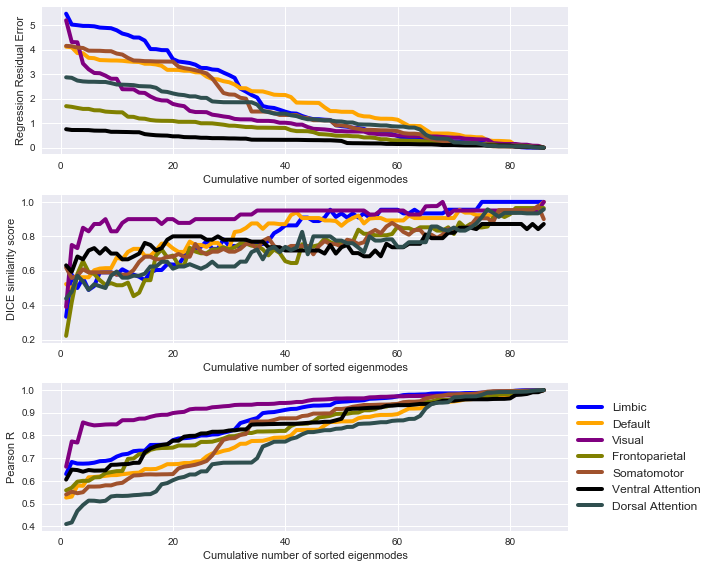

In [7]:
warnings.filterwarnings('ignore')

K = 86 # for number of eigenmodes
print(bh_default['x'])

#create brain object:
fc_brain = Brain.Brain()
fc_brain.add_connectome(hcp_dir)
fc_brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
fc_brain.bi_symmetric_c()
fc_brain.reduce_extreme_dir()

regr_all = np.zeros([K,7]) 
dice_all = np.zeros([K,7])
corr_all = np.zeros([K,7])
regr_all[:,0], dice_all[:,0], corr_all[:,0] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_limbic['x'][0], a = bh_limbic['x'][1], 
                                           s = bh_limbic['x'][2], fc_name = 'Limbic', num_em = K)

regr_all[:,1], dice_all[:,1], corr_all[:,1] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_default['x'][0], a = bh_default['x'][1], 
                                           s = bh_default['x'][2], fc_name = 'Default', num_em = K)

regr_all[:,2], dice_all[:,2], corr_all[:,2] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_visual['x'][0], a = bh_visual['x'][1], 
                                           s = bh_visual['x'][2], fc_name = 'Visual', num_em = K)

regr_all[:,3], dice_all[:,3], corr_all[:,3] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_front['x'][0], a = bh_front['x'][1], 
                                           s = bh_front['x'][2], fc_name = 'Frontoparietal', num_em = K)

regr_all[:,4], dice_all[:,4], corr_all[:,4] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_motor['x'][0], a = bh_motor['x'][1], 
                                           s = bh_motor['x'][2], fc_name = 'Somatomotor', num_em = K)

regr_all[:,5], dice_all[:,5], corr_all[:,5] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_dorsal['x'][0], a = bh_dorsal['x'][1], 
                                           s = bh_dorsal['x'][2], fc_name = 'Dorsal_Attention', num_em = K)

regr_all[:,6], dice_all[:,6], corr_all[:,6] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_ventral['x'][0], a = bh_ventral['x'][1], 
                                           s = bh_ventral['x'][2], fc_name = 'Ventral_Attention', num_em = K)

# Plot
x = np.arange(1,K+1)
plt.figure('Reconstruction Scores', figsize = [10,8])
plt.subplot(3,1,1)
custom_cycler = (cycler(color = ['blue','orange','purple','olive',
                          'sienna','black','darkslategray']))
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, regr_all, linewidth = 4)
plt.xlabel('Cumulative number of sorted eigenmodes')
plt.ylabel('Regression Residual Error')

plt.subplot(3,1,2)
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, dice_all, linewidth = 4)
plt.xlabel('Cumulative number of sorted eigenmodes')
plt.ylabel('DICE similarity score')

plt.subplot(3,1,3)
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, corr_all, linewidth = 4)
plt.xlabel('Cumulative number of sorted eigenmodes')
plt.ylabel('Pearson R')
plt.legend(['Limbic','Default','Visual','Frontoparietal','Somatomotor','Ventral Attention','Dorsal Attention'],
          fontsize = 'large', loc = 'center left',  bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('figures/r2_correlation.png', dpi = 300, bbox_inches ='tight')

### Visualize linear regression:

In [4]:
from nilearn import plotting
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Function for plotting with nilearn
def plot_glass_brain(coords, scores, cmap_name):
    """ Plot transparent brain renders
    Args:
        - color (list): Color indices
        - coords 
        - size
    Returns:
        -matplotlib object
    """
    if cmap_name == 'turbo':
        turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
        cmap = ListedColormap(turbo_colormap_data)
    else:
        cmap = cm.get_cmap(cmap_name)
    
    data = np.nan_to_num(scores)
    size = data*500
    #color = cmap((size/np.max(size)))
    color = cmap(data)
    connectome_array = np.array([[0]*86]*86)
    plotting.plot_connectome(connectome_array, coords, node_size = size, node_color = color, display_mode = 'xz')
    plt.gcf().set_size_inches(10, 5)

/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Default

mean correlation:  -0.0015366312480560823


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


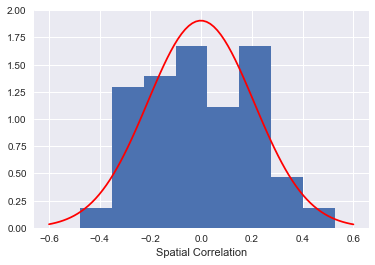

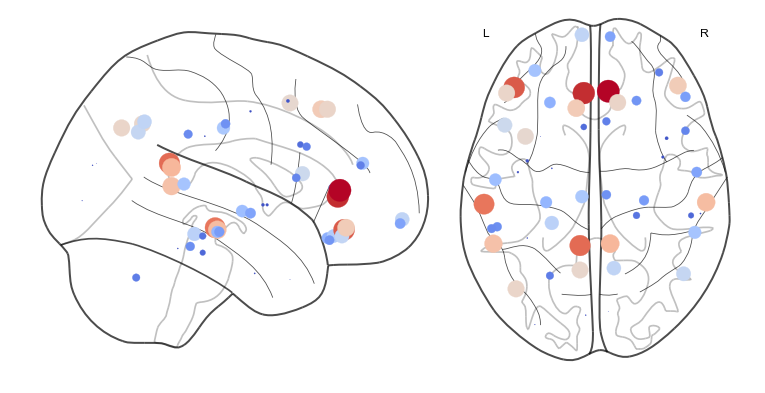

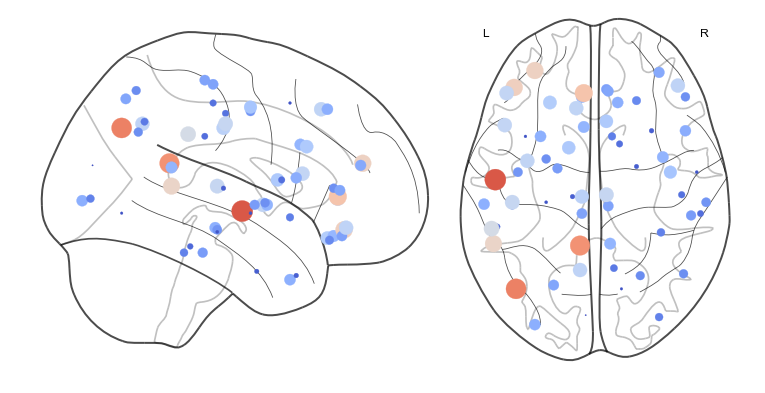

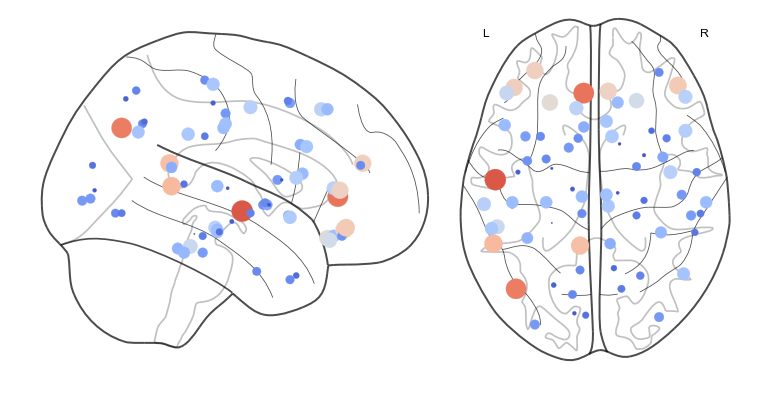

In [10]:
# Compute eigenmode dice with Brain:
dft_brain = Brain.Brain()
dft_brain.add_connectome(hcp_dir)
dft_brain.reorder_connectome(dft_brain.connectome, dft_brain.distance_matrix)
dft_brain.bi_symmetric_c()
dft_brain.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_default['x'][0]
dft_brain.add_laplacian_eigenmodes(w, alpha = bh_default['x'][1], speed = bh_default['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Default'].values)
corrs = np.squeeze(np.zeros([dft_brain.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), dft_brain.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
plt.figure('Canonical Network', figsize = [6,4])
plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
plt.xlabel('Spatial Correlation')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(corrs))
mu, sigma = stats.norm.fit(corrs)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Default'].values).reshape(-1,1)
corr_eigs = dft_brain.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Default'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr- 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/default_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/default_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = dft_brain.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr- 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/default_10eig.png', dpi=300, bbox_inches = 'tight')

### Frontoparietal

mean correlation:  -0.04550349841350991


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


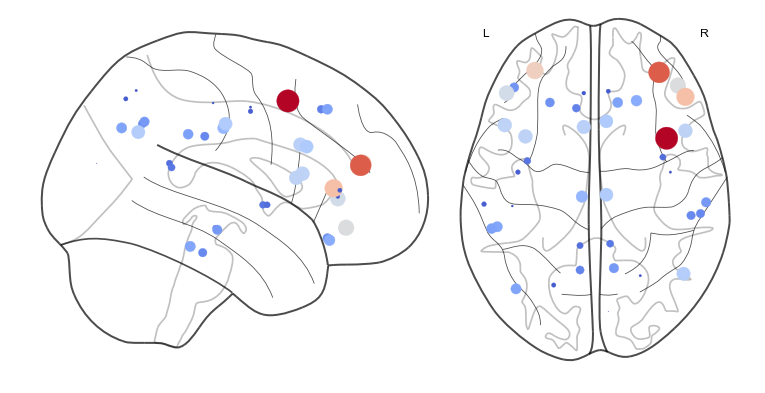

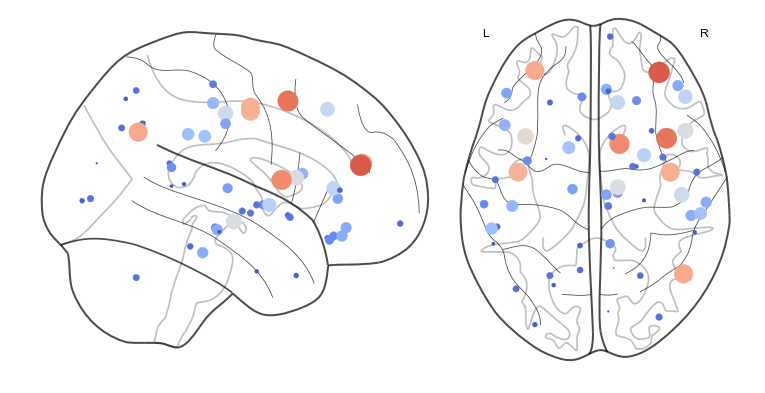

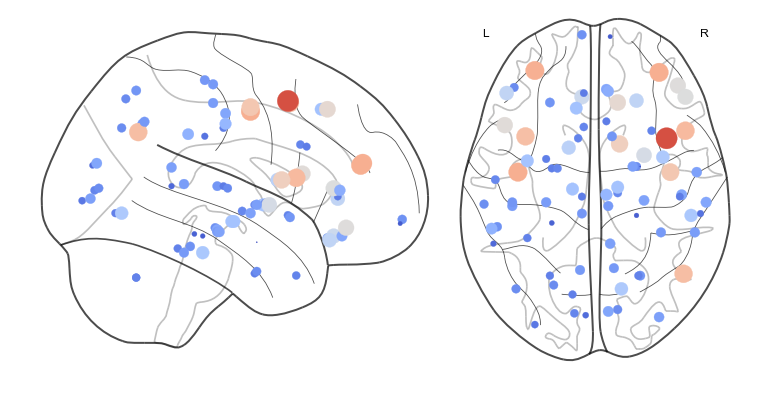

In [11]:
# Compute eigenmode dice with Brain:
front = Brain.Brain()
front.add_connectome(hcp_dir)
front.reorder_connectome(front.connectome, front.distance_matrix)
front.bi_symmetric_c()
front.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_front['x'][0]
front.add_laplacian_eigenmodes(w, alpha = bh_front['x'][1], speed = bh_front['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Frontoparietal'].values)
corrs = np.squeeze(np.zeros([front.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), front.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Frontoparietal'].values).reshape(-1,1)
corr_eigs = front.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Frontoparietal'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr- 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/Fronto_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/Fronto_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = front.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr - 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/Fronto_10eig.png', dpi=300, bbox_inches = 'tight')

### Limbic

mean correlation:  0.06607941490013136


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


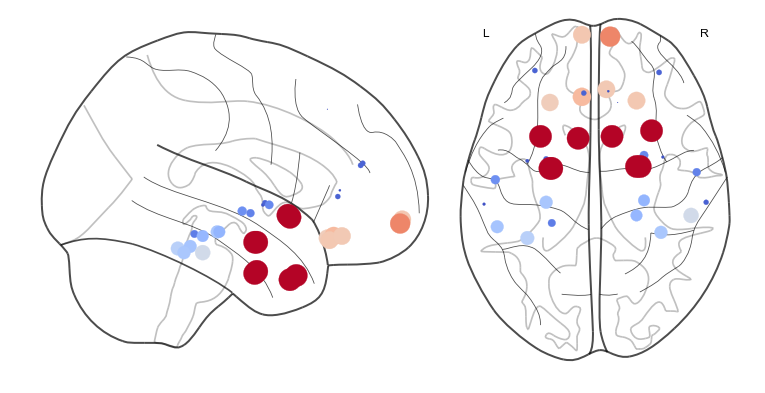

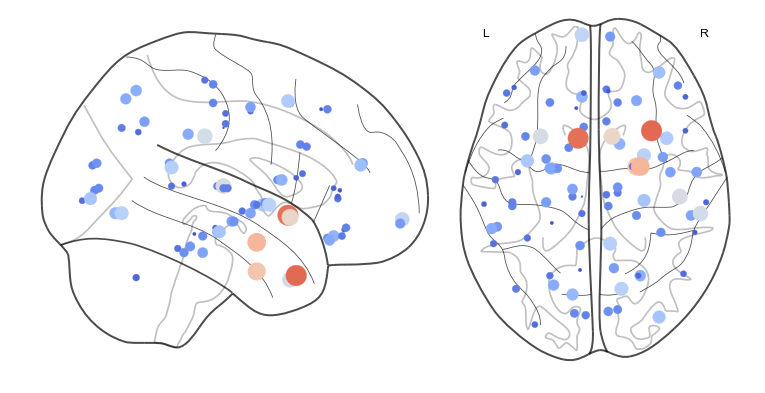

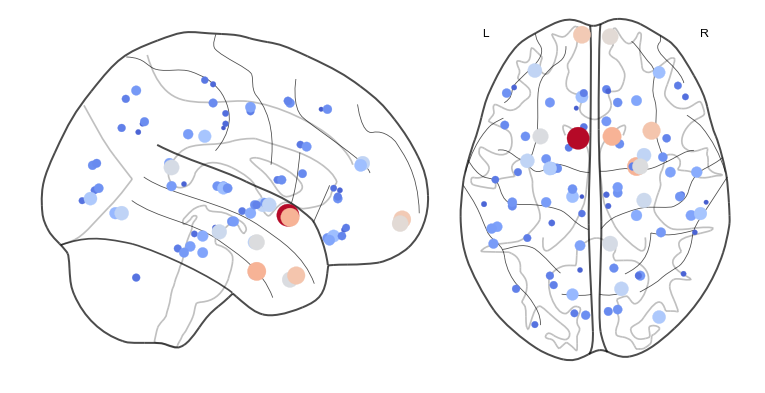

In [16]:
# Compute eigenmode dice with Brain:
limbic = Brain.Brain()
limbic.add_connectome(hcp_dir)
limbic.reorder_connectome(limbic.connectome, limbic.distance_matrix)
limbic.bi_symmetric_c()
limbic.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_limbic['x'][0]
limbic.add_laplacian_eigenmodes(w, alpha = bh_limbic['x'][1], speed = bh_limbic['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Limbic'].values)
corrs = np.squeeze(np.zeros([limbic.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), limbic.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Limbic'].values).reshape(-1,1)
corr_eigs = limbic.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(comb_corr)
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Limbic'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr# - 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/limbic_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/limbic_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = limbic.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(comb_corr)

GB_10eigs = comb_corr# - 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/limbic_10eig.png', dpi=300, bbox_inches = 'tight')

### Visual

mean correlation:  -0.05866659475387147


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


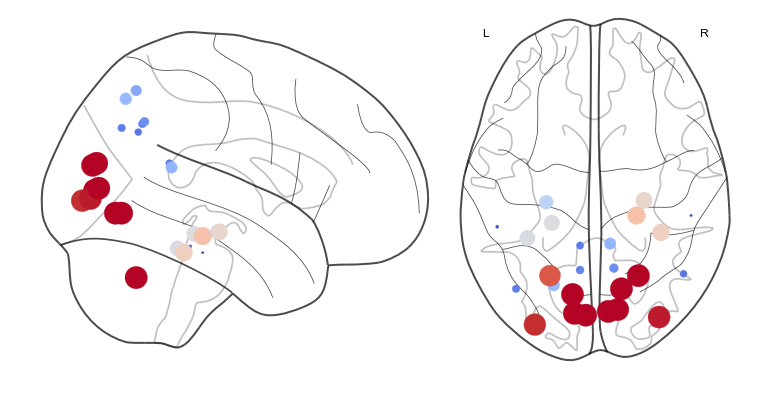

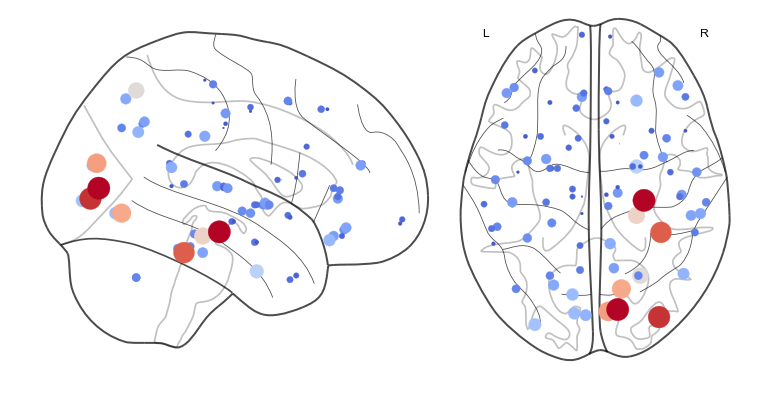

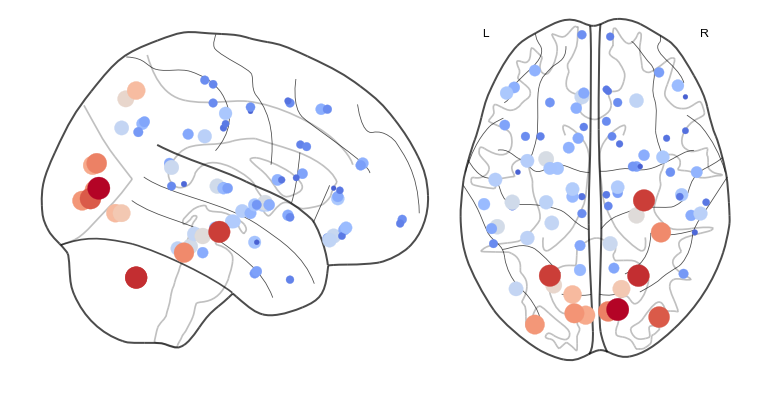

In [17]:
# Compute eigenmode dice with Brain:
visual = Brain.Brain()
visual.add_connectome(hcp_dir)
visual.reorder_connectome(visual.connectome, visual.distance_matrix)
visual.bi_symmetric_c()
visual.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_visual['x'][0]
visual.add_laplacian_eigenmodes(w, alpha = bh_visual['x'][1], speed = bh_visual['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Visual'].values)
corrs = np.squeeze(np.zeros([visual.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), visual.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Visual'].values).reshape(-1,1)
corr_eigs = visual.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Visual'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr#- 1*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/visual_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/visual_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = visual.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr# - 1*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/visual_10eig.png', dpi=300, bbox_inches = 'tight')

mean correlation:  0.03855321159360758


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


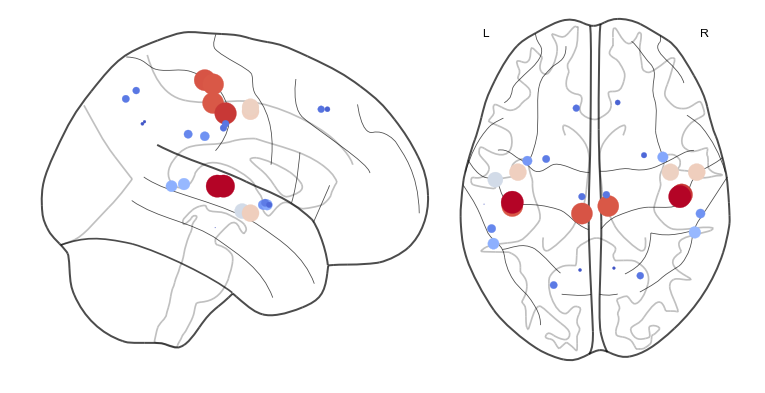

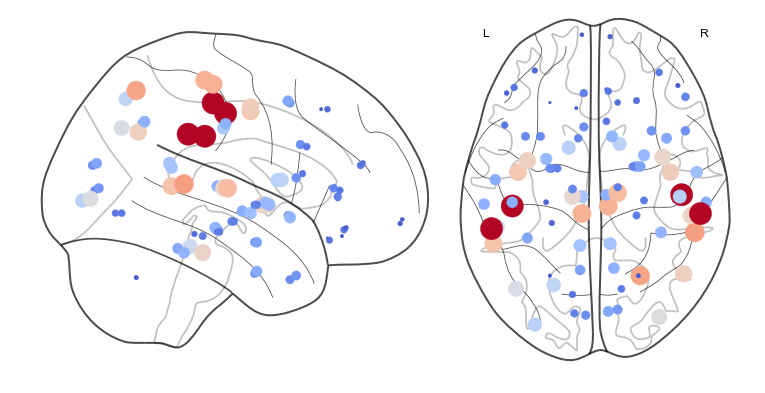

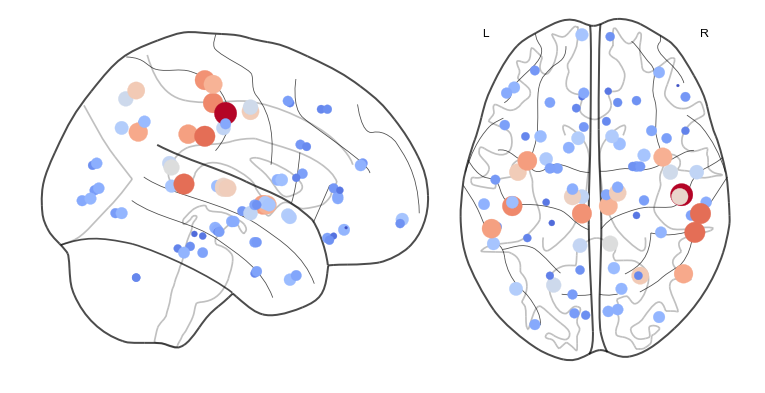

In [18]:
# Compute eigenmode dice with Brain:
motor = Brain.Brain()
motor.add_connectome(hcp_dir)
motor.reorder_connectome(motor.connectome, motor.distance_matrix)
motor.bi_symmetric_c()
motor.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_motor['x'][0]
motor.add_laplacian_eigenmodes(w, alpha = bh_motor['x'][1], speed = bh_motor['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Somatomotor'].values)
corrs = np.squeeze(np.zeros([motor.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), motor.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Somatomotor'].values).reshape(-1,1)
corr_eigs = motor.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Somatomotor'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr#- 1*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/motor_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/motor_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = motor.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr# - 1*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/motor_10eig.png', dpi=300, bbox_inches = 'tight')

mean correlation:  0.023692765503878777


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


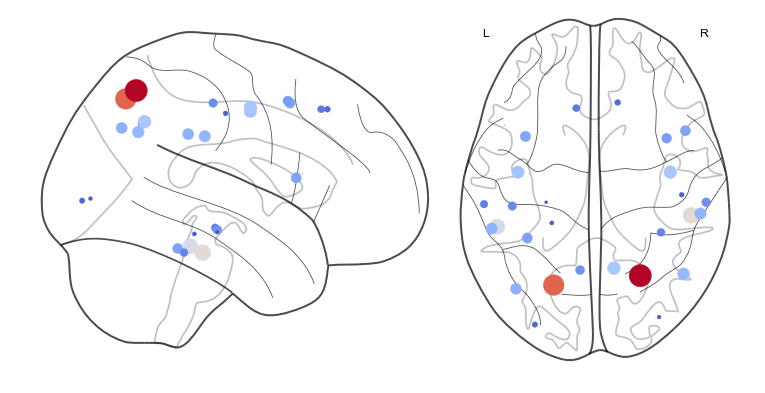

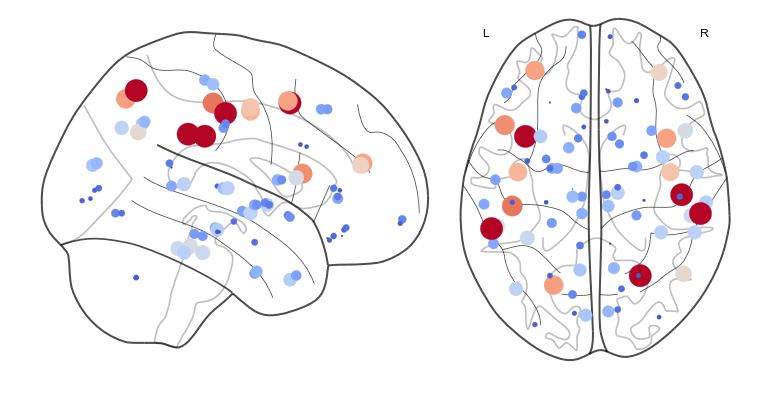

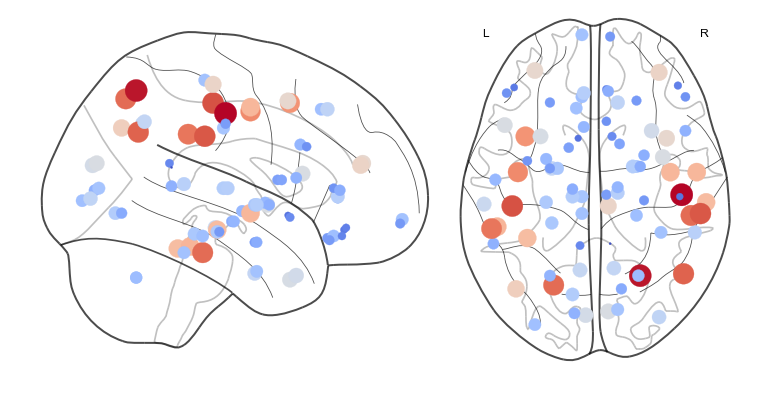

In [21]:
# Compute eigenmode dice with Brain:
dorsal = Brain.Brain()
dorsal.add_connectome(hcp_dir)
dorsal.reorder_connectome(dorsal.connectome, dorsal.distance_matrix)
dorsal.bi_symmetric_c()
dorsal.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_dorsal['x'][0]
dorsal.add_laplacian_eigenmodes(w, alpha = bh_dorsal['x'][1], speed = bh_dorsal['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Dorsal_Attention'].values)
corrs = np.squeeze(np.zeros([dorsal.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), dorsal.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Dorsal_Attention'].values).reshape(-1,1)
corr_eigs = dorsal.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Dorsal_Attention'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr#- 1*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/dorsal_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/dorsal_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = dorsal.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr# - 1*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/dorsal_10eig.png', dpi=300, bbox_inches = 'tight')

mean correlation:  -0.004194453924897753


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


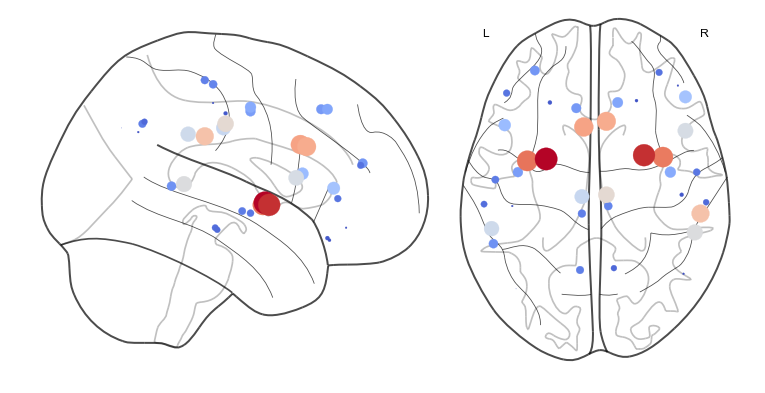

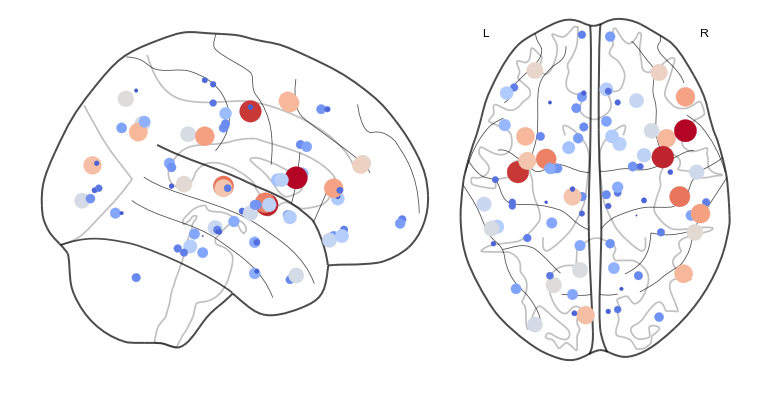

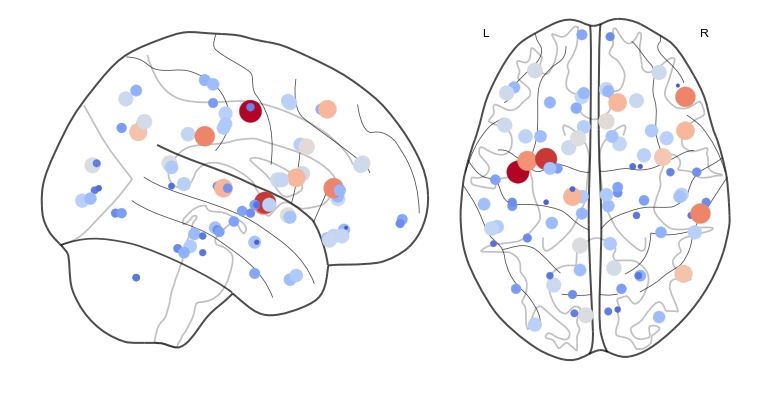

In [23]:
# Compute eigenmode dice with Brain:
ventral = Brain.Brain()
ventral.add_connectome(hcp_dir)
ventral.reorder_connectome(ventral.connectome, ventral.distance_matrix)
ventral.bi_symmetric_c()
ventral.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_ventral['x'][0]
ventral.add_laplacian_eigenmodes(w, alpha = bh_ventral['x'][1], speed = bh_ventral['x'][2], vis = False)

# correlation:
canon_network = np.nan_to_num(DK_df_normalized.loc['Ventral_Attention'].values)
corrs = np.squeeze(np.zeros([ventral.norm_eigenmodes.shape[1],1]))
for e in np.arange(0, len(corrs)):
    prcorr = pearsonr(np.squeeze(canon_network), ventral.norm_eigenmodes[:,e])[0]
    corrs[e] = prcorr
        
ntw_opt_corr = np.round(corrs,3)
ordered_corr = np.argsort(-ntw_opt_corr)

# Compute mean corr for chosen network:
mean_corr = np.mean(corrs)
print("mean correlation: ", mean_corr)

# plot:
#plt.figure('Canonical Network', figsize = [6,4])
#plt.hist(corrs, bins = 8, density = True, histtype = 'bar')
#plt.xlabel('Spatial Correlation')
#xvals = plt.xticks()[0]
#xmin, xmax = min(xvals), max(xvals)
#xbins = np.linspace(xmin, xmax, len(corrs))
#mu, sigma = stats.norm.fit(corrs)
#gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
#plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

K = 1

canon_network = np.nan_to_num(DK_df_normalized.loc['Ventral_Attention'].values).reshape(-1,1)
corr_eigs = ventral.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])

#plot
GB_network = minmax_scale(DK_df_normalized.loc['Ventral_Attention'].values)
GB_network = GB_network# - np.std(GB_network)
GB_eigmode = comb_corr# - 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_network, 'coolwarm')
plt.savefig('figures/ventral_GB.png', dpi = 300, bbox_inches = 'tight')
plot_glass_brain(coords, GB_eigmode, 'coolwarm')
plt.savefig('figures/ventral_eig.png', dpi = 300, bbox_inches = 'tight')

K = 10
corr_eigs = ventral.norm_eigenmodes[:,ordered_corr[0:K]]
coef, r, _, _ = np.linalg.lstsq(corr_eigs, canon_network, rcond = None)
comb_corr = np.matmul(corr_eigs, np.asarray(coef))
comb_corr = np.squeeze(minmax_scale(comb_corr))

GB_10eigs = comb_corr# - 0.5*np.std(comb_corr)
plot_glass_brain(coords, GB_10eigs, 'coolwarm')
plt.savefig('figures/ventral_10eig.png', dpi = 300, bbox_inches = 'tight')

In [38]:
from nilearn import plotting
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Function for plotting with nilearn
def plot_uniform_brains(color, coords, size):
    """Plot a glass brain for a 90 regions ATLAS with nodes colored by `color`.

    Args:
        color (list): Color indices. e.g. [0,1,1,0] will color nodes [1,2] differently.

    Returns:
        matplotlib.plot: A plot object.

    """

    connec = np.array([[0]*86]*86)

    plotting.plot_connectome(connec, coords, node_size = size, node_color=color, display_mode='xz')

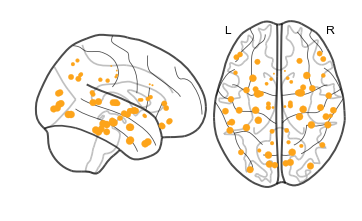

In [58]:
# Compute eigenmode dice with Brain:
pbrain = Brain.Brain()
pbrain.add_connectome(hcp_dir)
pbrain.reorder_connectome(pbrain.connectome, pbrain.distance_matrix)
pbrain.bi_symmetric_c()
pbrain.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*10
pbrain.add_laplacian_eigenmodes(w, alpha = 1, speed = 10, vis = True)

plot_uniform_brains([[0.9921875,0.64453125,0.1]]*86, coords, pbrain.norm_eigenmodes[:,0]*50)
plt.savefig('figures/fig1/eig1.png', dpi = 300, bbox_inches = 'tight')